In [ ]:
import pandas as pd
import numpy as np
import os
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/ICT 8 Hands-On/private-key.json"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bqclient = bigquery.Client()

# Download query results.
query_string = """
SELECT * FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2018
UNION ALL
SELECT * FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2019
UNION ALL
SELECT * FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2020
"""

df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
    )
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56999 entries, 0 to 56998
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               56999 non-null  object             
 1   oder_detail_id         56999 non-null  object             
 2   order_datetime         56999 non-null  datetime64[ns, UTC]
 3   item_id                56999 non-null  object             
 4   item_name              56999 non-null  object             
 5   cat_name               56999 non-null  object             
 6   price                  56999 non-null  float64            
 7   product_quantity       56999 non-null  Int64              
 8   percentage_commission  56999 non-null  float64            
 9   payment_method         56999 non-null  object             
 10  payment_datetime       56999 non-null  datetime64[ns, UTC]
 11  processed_datetime     53325 non-null  datetime64[ns, 

In [ ]:
df.isnull().sum()

order_id                    0
oder_detail_id              0
order_datetime              0
item_id                     0
item_name                   0
cat_name                    0
price                       0
product_quantity            0
percentage_commission       0
payment_method              0
payment_datetime            0
processed_datetime       3674
delivered_datetime       4004
received_datetime        3712
settled_datetime         3920
buyer_id                    0
seller_id                   0
order_source                0
buyer_province_name         4
buyer_city_name             4
logistic_name               0
dtype: int64

## Data Cleansing

In [ ]:
query_string = """
WITH
  data_2018 AS (
  SELECT
    payment_method,
    2018 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.ralali_transactions_Q1_2018`
  GROUP BY
    payment_method
  ORDER BY
    total DESC ),
  data_2019 AS (
  SELECT
    payment_method,
    2019 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.ralali_transactions_Q1_2019`
  GROUP BY
    payment_method
  ORDER BY
    total DESC ),
  data_2020 AS (
  SELECT
    payment_method,
    2020 AS year,
    COUNT(order_id) AS total
  FROM
    `bitlabs-dab.G_CID_01.ralali_transactions_Q1_2020`
  GROUP BY
    payment_method
  ORDER BY
    total DESC )
SELECT
  *
FROM (
  SELECT
    payment_method,
    year,
    total
  FROM
    data_2018
  UNION ALL
  SELECT
    payment_method,
    year,
    total
  FROM
    data_2019
  UNION ALL
  SELECT
    payment_method,
    year,
    total
  FROM
    data_2020
  GROUP BY
    payment_method,
    year,
    total
  ORDER BY
    payment_method,
    year) src PIVOT (SUM(total) FOR Year IN (2018,
      2019,
      2020) ) piv
ORDER BY
  payment_method
"""

payments_per_year = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)

In [ ]:
payments_per_year

,payment_method,_2018,_2019,_2020
0,BCA,<NA>,2536,5548
1,BCA Bank Transfer,5819,6489,19752
2,BCA Klik Pay,<NA>,<NA>,2
3,BII,55,2,7
4,BNI,178,92,1358
5,BNI Bank Transfer,304,207,268
6,BRI,138,107,531
7,BRI Bank Transfer,616,440,183
8,Bank BCA,<NA>,210,1519
9,Credit Card,439,81,37


In [ ]:
payments_per_year.fillna(value=0)

,payment_method,_2018,_2019,_2020
0,BCA,0,2536,5548
1,BCA Bank Transfer,5819,6489,19752
2,BCA Klik Pay,0,0,2
3,BII,55,2,7
4,BNI,178,92,1358
5,BNI Bank Transfer,304,207,268
6,BRI,138,107,531
7,BRI Bank Transfer,616,440,183
8,Bank BCA,0,210,1519
9,Credit Card,439,81,37


In [ ]:
query_string = """
WITH
c
AS
(
WITH b
AS
(
WITH a
AS
(
SELECT *
        FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2018
UNION ALL
SELECT *
        FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2019
UNION ALL
SELECT *
        FROM bitlabs-dab.G_CID_01.ralali_transactions_Q1_2020
)
SELECT COUNT(order_id) AS total_payment
        ,CASE
        WHEN payment_method
        IN('BCA Bank Transfer'
        ,'Mandiri Bank Transfer'
        ,'BNI Bank Transfer'
        ,'BRI'
        ,'BRI Bank Transfer'
        ,'Mandiri'
        ,'BNI'
        ,'BII'
        ,'Mandiri Internet Banking'
        ,'Permata'
        ,'DBS Bank Transfer'
        ,'Bank BCA'
        ,'BCA'
        ,'BCA Klik Pay') THEN 'Bank Transfer'
        WHEN payment_method
        IN('Ralali Wallet'
        ,'Ovo') THEN 'e-Wallet'
        WHEN payment_method
        IN('Payment Nothing') THEN 'TOP'
        WHEN payment_method
        IN ('Credit Card','Kredivo') THEN 'Credit Card'
        END AS method
FROM a
GROUP BY method
)
SELECT method
        ,total_payment
        , SUM(total_payment) OVER() AS total
FROM b
)
SELECT method
        ,ROUND((total_payment/total)*100,3) AS percentage
FROM c
ORDER BY 2 DESC
"""

df_payments = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)

In [ ]:
df_payments

,method,percentage
0,Bank Transfer,86.830
1,e-Wallet,12.037
2,Credit Card,1.023
3,TOP,0.111


## Detecting Outliers

In [ ]:
df['price']

0        510000.0
1        510000.0
2        610000.0
3        610000.0
4        610000.0
           ...   
56994     20000.0
56995     20000.0
56996     20000.0
56997     29000.0
56998     32000.0
Name: price, Length: 56999, dtype: float64

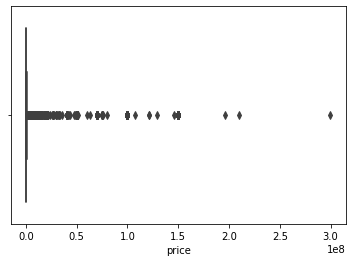

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x = df['price'])
plt.show()

In [ ]:
df['product_quantity']

0        11
1        11
2        11
3        11
4        11
         ..
56994    11
56995    11
56996    11
56997    11
56998    25
Name: product_quantity, Length: 56999, dtype: Int64

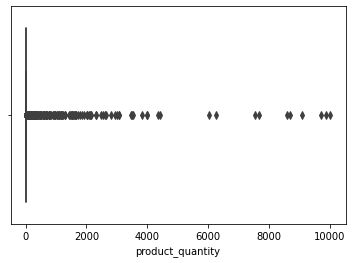

In [ ]:
sns.boxplot(x = df['product_quantity'])
plt.show()

In [ ]:
df['percentage_commission']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
56994    3.0
56995    3.0
56996    3.0
56997    3.0
56998    2.5
Name: percentage_commission, Length: 56999, dtype: float64

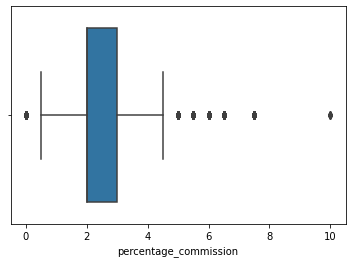

In [ ]:
sns.boxplot(x = df['percentage_commission'])
plt.show()

In [ ]:
df['product_quantity'].quantile(0.25)
df['product_quantity'].quantile(0.75)

Q1 = df['product_quantity'].quantile(0.25)
Q3 = df['product_quantity'].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

In [ ]:
batas_bawah

6.5

In [ ]:
batas_atas

18.5

In [ ]:
df[(df['product_quantity'] < batas_bawah) | (df['product_quantity'] > batas_atas)].count()

order_id                 7171
oder_detail_id           7171
order_datetime           7171
item_id                  7171
item_name                7171
cat_name                 7171
price                    7171
product_quantity         7171
percentage_commission    7171
payment_method           7171
payment_datetime         7171
processed_datetime       6773
delivered_datetime       6667
received_datetime        6574
settled_datetime         6572
buyer_id                 7171
seller_id                7171
order_source             7171
buyer_province_name      7171
buyer_city_name          7171
logistic_name            7171
dtype: int64

## Data Transformation

In [ ]:
df_fix = df.copy()

In [ ]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56999 entries, 0 to 56998
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               56999 non-null  object             
 1   oder_detail_id         56999 non-null  object             
 2   order_datetime         56999 non-null  datetime64[ns, UTC]
 3   item_id                56999 non-null  object             
 4   item_name              56999 non-null  object             
 5   cat_name               56999 non-null  object             
 6   price                  56999 non-null  float64            
 7   product_quantity       56999 non-null  Int64              
 8   percentage_commission  56999 non-null  float64            
 9   payment_method         56999 non-null  object             
 10  payment_datetime       56999 non-null  datetime64[ns, UTC]
 11  processed_datetime     53325 non-null  datetime64[ns, 

In [ ]:
df_fix['gmv'] = df['price'] * df['product_quantity']
df_fix['revenue'] = ((df['price']*df['product_quantity']) * df['percentage_commission']) / 100

In [ ]:
df_fix[['order_id','price','percentage_commission','gmv','revenue']].tail(5)

,order_id,price,percentage_commission,gmv,revenue
56994,hMNVJu7pe/56r9IMer9EOhMaspNepjbOjY+yzwuxhbyMeX...,20000.0,3.0,220000.0,6600.0
56995,Kyr1swAjeR37xIsuF5FDUbp7QtkHWpbNByLa/Smk4It3Jv...,20000.0,3.0,220000.0,6600.0
56996,vUVI5D2/Fkw+uJCP/prvGKQR7pS6ysgu+YBpy7XKD0LDfI...,20000.0,3.0,220000.0,6600.0
56997,9l6zCubPWS1YrZp00WRBFOxRqWaqOid00L+C28qt8PhjEj...,29000.0,3.0,319000.0,9570.0
56998,0b8ttj22Y4JOZSMxrgXb0E4pd5MD7e+Pmy8Zk5rrK5NssN...,32000.0,2.5,800000.0,20000.0


In [ ]:
def func(row):
  if row['order_datetime'] is not pd.NaT and row['payment_datetime'] is not pd.NaT and row['processed_datetime'] is not pd.NaT and row['delivered_datetime'] is not pd.NaT and row['received_datetime'] is not pd.NaT and row['settled_datetime'] is not pd.NaT:
    return 'true'
  elif row['payment_method'] is not pd.NaT and row['received_datetime'] is not pd.NaT:
    return 'false'

df_fix['is_refund'] = df_fix.apply(func, axis=1)

In [ ]:
df_fix[['order_id','gmv','revenue','is_refund']].head(5)

,order_id,gmv,revenue,is_refund
0,RY8M4nM5qeRgOCHUc4sPamPxJ98EpP52G2I8yW2+jz9/LB...,5610000.0,112200.0,true
1,1z0Vi8I4h3P6gbhqKjTUhDXNMZpQf0MIs3A9hY2S/FoF70...,5610000.0,112200.0,true
2,RA3C3EZUWnZA1gQwLsM4MMA2QBsdniTTDOXP3GZvv/b0h2...,6710000.0,134200.0,true
3,904UDskup/Qtr2+ZAc7Xqiz/CfG2Q8uz2r8wSAsQRE69cR...,6710000.0,134200.0,true
4,7afmOZCVElvGcZerV4+2hiGtWn6yCME7mJTqk2Yl6i0dLh...,6710000.0,134200.0,true


## Exploratory Data Analysis

In [ ]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56999 entries, 0 to 56998
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               56999 non-null  object             
 1   oder_detail_id         56999 non-null  object             
 2   order_datetime         56999 non-null  datetime64[ns, UTC]
 3   item_id                56999 non-null  object             
 4   item_name              56999 non-null  object             
 5   cat_name               56999 non-null  object             
 6   price                  56999 non-null  float64            
 7   product_quantity       56999 non-null  Int64              
 8   percentage_commission  56999 non-null  float64            
 9   payment_method         56999 non-null  object             
 10  payment_datetime       56999 non-null  datetime64[ns, UTC]
 11  processed_datetime     53325 non-null  datetime64[ns, 

In [ ]:
total_order = df_fix['order_id'].count()
print('Total_Order :', total_order)

Total_Order : 56999


In [ ]:
category_revenue = df_fix[['cat_name', 'revenue']]
df_group = category_revenue.groupby(['cat_name']).sum()
df_group.sort_values(by=['revenue'], inplace=True, ascending=False)
df_group

,revenue
cat_name,
Computer & Communication,4674947540.365
Automotive & Transportation,3680248759.85
Agriculture & Food,1108239475.615
Machinery & Industrial Parts,513947693.56
Electronics,373019336.48
Building Materials,281824133.35
Health & Medical,100170766.35
Office & Store Supplies,61040248.225
"Beauty, Sport & Fashion",49432906.785


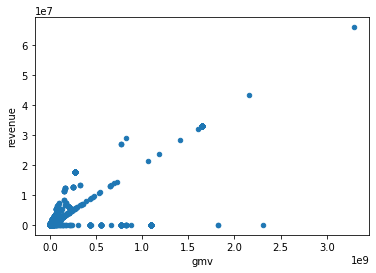

In [ ]:
df_fix.plot.scatter(x='gmv', y='revenue');